
# Population Health Trends Dashboard – Portfolio Analysis
**Role:** Data Analyst, Health Organization (Independent Project)  
**Goal:** Use simulated CIHI/Statistics Canada–style datasets to monitor provincial health outcomes, compare regions, and inform resource planning.

---

## 1) Problem Statement
Provincial leaders need an up-to-date view of population health to guide resource allocation and performance improvement. We will:
- Track **mortality**, **hospitalizations**, and **readmissions**
- Compare provinces and regions
- Adjust for age structure to ensure fair comparisons
- Identify **improvement opportunities** and model short-term trends

**Primary Questions**
1. Which provinces have the highest/lowest **age-standardized mortality rates (ASMR)**?
2. How are **hospitalizations** and **readmissions** trending over time?
3. What factors correlate with outcomes (e.g., spending per capita, access, risk behaviours)?
4. Which regions should be prioritized for intervention?

---
## 2) Data
We use the following inputs (simulated but structured like CIHI/StatsCan extracts):
- `health_trends_age_breakdown.csv`: province-year by **age group** and **sex**, with outcome rates and populations.
- `health_trends_prov_year.csv`: province-year **aggregates** (KPIs, behaviour, resources).
- `standard_population.csv`: age group **weights** for direct standardization.
- `lookup_provinces.csv`: province code ↔ name, region, rurality metadata.
- `data_dictionary.csv`: column descriptions.

> Note: Real projects would also include data quality checks, data governance notes, and privacy considerations.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Display options
pd.set_option('display.max_columns', 50)

# Your paths (files in the current working directory)
prov_year        = pd.read_csv("health_trends_prov_year.csv")
age_breakdown    = pd.read_csv("health_trends_age_breakdown.csv")
provinces_lookup = pd.read_csv("lookup_provinces.csv")
std_pop          = pd.read_csv("standard_population.csv")
data_dict        = pd.read_csv("data_dictionary.csv")

# Quick peek to confirm loads
data_dict.head()


,column,description,type
0,province_code,Two-letter province/territory code,dim
1,province,Province or territory name,dim
2,region,Geographic region grouping,dim
3,rural_pct,"Percent of residents in rural areas (%, 0–100)",dim/feature
4,year,Calendar year (2015–2024),dim


In [4]:
print("age_breakdown:", age_breakdown.shape, list(age_breakdown.columns)[:10], "...")
print("prov_year:", prov_year.shape, list(prov_year.columns)[:10], "...")
print("std_pop:", std_pop.shape, std_pop.head().to_dict(orient="records"))
print("provinces_lookup:", provinces_lookup.shape, provinces_lookup.head().to_dict(orient="records")[:3])


age_breakdown: (1040, 9) ['province_code', 'province', 'year', 'age_group', 'sex', 'population', 'deaths', 'diabetes_cases', 'hospitalizations'] ...
prov_year: (130, 22) ['province_code', 'province', 'region', 'rural_pct', 'year', 'population', 'life_expectancy_years', 'crude_mortality_per_100k', 'asmr_per_100k', 'diabetes_prevalence_pct'] ...
std_pop: (4, 2) [{'age_group': '0-14', 'standard_weight': 0.165}, {'age_group': '15-44', 'standard_weight': 0.405}, {'age_group': '45-64', 'standard_weight': 0.265}, {'age_group': '65+', 'standard_weight': 0.165}]
provinces_lookup: (13, 4) [{'province_code': 'NL', 'province': 'Newfoundland and Labrador', 'region': 'Atlantic', 'rural_pct': 41}, {'province_code': 'PE', 'province': 'Prince Edward Island', 'region': 'Atlantic', 'rural_pct': 46}, {'province_code': 'NS', 'province': 'Nova Scotia', 'region': 'Atlantic', 'rural_pct': 43}]


## 3) Cleaning & Preparation

In [5]:
# Ensure consistent casing/types
age_breakdown["age_group"] = age_breakdown["age_group"].astype(str)
std_pop["age_group"]       = std_pop["age_group"].astype(str)

# Verify weights sum to 1
w_sum = std_pop["standard_weight"].sum()
if not np.isclose(w_sum, 1.0):
    std_pop["standard_weight"] = std_pop["standard_weight"] / w_sum
print("Standard pop weights sum:", std_pop["standard_weight"].sum())

# Basic NA checks
print("Missing values (age_breakdown):\n",
      age_breakdown.isna().sum().sort_values(ascending=False).head(10))
print("Missing values (prov_year):\n",
      prov_year.isna().sum().sort_values(ascending=False).head(10))


Standard pop weights sum: 1.0
Missing values (age_breakdown):
 province_code       0
province            0
year                0
age_group           0
sex                 0
population          0
deaths              0
diabetes_cases      0
hospitalizations    0
dtype: int64
Missing values (prov_year):
 province_code                        0
province                             0
nurses_per_100k                      0
physicians_per_100k                  0
health_expenditure_per_capita_cad    0
immunization_flu_pct                 0
primary_care_access_pct              0
obesity_rate_pct                     0
physical_activity_pct                0
smoking_rate_pct                     0
dtype: int64


## 4) KPIs (National Overview)

In [6]:
def wavg(s, w): 
    return (s * w).sum() / w.sum()

nat_w = (prov_year.groupby('year', as_index=False)
         .apply(lambda g: pd.Series({
             'population': g['population'].sum(),
             'mortality_rate': wavg(g['crude_mortality_per_100k'], g['population']),
             'asmr': wavg(g['asmr_per_100k'], g['population']),
             'hospitalizations': wavg(g['hospitalizations_per_100k'], g['population']),
             'readmissions': wavg(g['readmissions_30d_pct'], g['population']),
         }))
         .reset_index(drop=True))
nat_w.head()


/var/folders/j5/l4n1h3z533nbg7ks96r5chn80000gn/T/ipykernel_14867/4162382816.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,year,population,mortality_rate,asmr,hospitalizations,readmissions
0,2015,38471755.0,733.493425,728.048940,6375.552280,7.897571
1,2016,38807751.0,731.977014,726.530845,6442.054193,7.902465
2,2017,39147021.0,702.752995,697.305151,6243.264892,7.192033
3,2018,39489599.0,728.514230,723.064721,6441.097073,7.336545
4,2019,39835515.0,726.984276,721.533113,6314.843959,7.247305


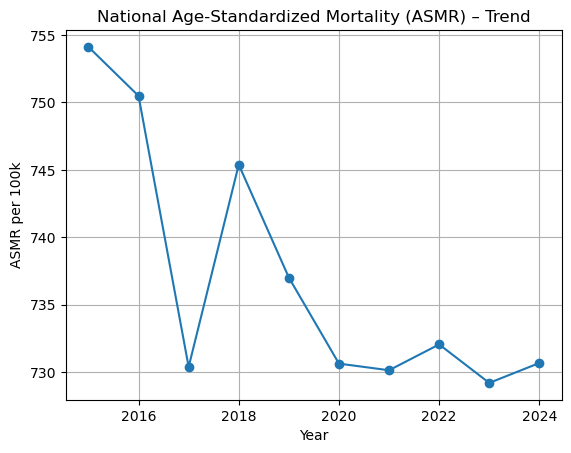

In [9]:
# Plot: National ASMR trend
plt.figure()
plt.plot(nat['year'], nat['asmr'], marker='o')
plt.title('National Age-Standardized Mortality (ASMR) – Trend')
plt.xlabel('Year'); plt.ylabel('ASMR per 100k')
plt.grid(True)
plt.show()


## 5) Methods: Direct Age Standardization (recompute ASMR)

In [10]:

# Recompute ASMR from the age-level file to validate provincial ASMR in prov_year

# 1) Aggregate to province-year-age (sum over sex), then compute age-specific rates
age_agg = (age_breakdown
           .groupby(['province_code', 'province', 'year', 'age_group'], as_index=False)
           .agg(population=('population','sum'),
                deaths=('deaths','sum')))

age_agg['age_rate_per_100k'] = (age_agg['deaths'] / age_agg['population']) * 100000

# 2) Merge standard population weights
age_std = age_agg.merge(std_pop, on='age_group', how='left')

# 3) Compute ASMR per province-year: sum(age_rate * standard_weight)
recalc_asmr = (age_std
               .assign(weighted=lambda d: d['age_rate_per_100k'] * d['standard_weight'])
               .groupby(['province_code','province','year'], as_index=False)['weighted']
               .sum()
               .rename(columns={'weighted':'recalc_asmr_per_100k'}))

recalc_asmr.head()


,province_code,province,year,recalc_asmr_per_100k
0,AB,Alberta,2015,447.890830
1,AB,Alberta,2016,441.940468
2,AB,Alberta,2017,414.565211
3,AB,Alberta,2018,418.955171
4,AB,Alberta,2019,448.512118


In [11]:
asmr_compare = (prov_year
                .merge(recalc_asmr, on=['province_code','province','year'], how='left'))
asmr_compare['asmr_diff'] = asmr_compare['recalc_asmr_per_100k'] - asmr_compare['asmr_per_100k']
asmr_compare[['province_code','year','asmr_per_100k','recalc_asmr_per_100k','asmr_diff']].head(12)


,province_code,year,asmr_per_100k,recalc_asmr_per_100k,asmr_diff
0,NL,2015,759.6,436.274503,-323.325497
1,NL,2016,741.8,437.477977,-304.322023
2,NL,2017,738.8,445.027789,-293.772211
3,NL,2018,759.9,455.427107,-304.472893
4,NL,2019,728.7,435.931746,-292.768254
5,NL,2020,730.3,426.620998,-303.679002
6,NL,2021,729.7,426.773397,-302.926603
7,NL,2022,728.1,425.369648,-302.730352
8,NL,2023,739.6,429.114458,-310.485542
9,NL,2024,745.5,421.370581,-324.129419


In [12]:
# Join with provincial table to compare
asmr_compare = (
    prov_year
    .merge(recalc_asmr, on=["province_code","province","year"], how="left")
    [["province","year","asmr_per_100k","recalc_asmr_per_100k"]]
)
asmr_compare.head()


,province,year,asmr_per_100k,recalc_asmr_per_100k
0,Newfoundland and Labrador,2015,759.6,436.274503
1,Newfoundland and Labrador,2016,741.8,437.477977
2,Newfoundland and Labrador,2017,738.8,445.027789
3,Newfoundland and Labrador,2018,759.9,455.427107
4,Newfoundland and Labrador,2019,728.7,435.931746


In [ ]:

# Plot: Example province comparison of provided vs recalculated ASMR
example_prov = asmr_compare['province'].unique()[0]
tmp = asmr_compare[asmr_compare['province']==example_prov].sort_values('year')

plt.figure()
plt.plot(tmp['year'], tmp['asmr_per_100k'], marker='o', label='Provided ASMR')
plt.plot(tmp['year'], tmp['recalc_asmr_per_100k'], marker='s', label='Recalc ASMR')
plt.title(f'ASMR Validation – {example_prov}')
plt.xlabel('Year'); plt.ylabel('ASMR per 100k')
plt.legend()
plt.grid(True)
plt.show()

## 6) Regional Comparisons

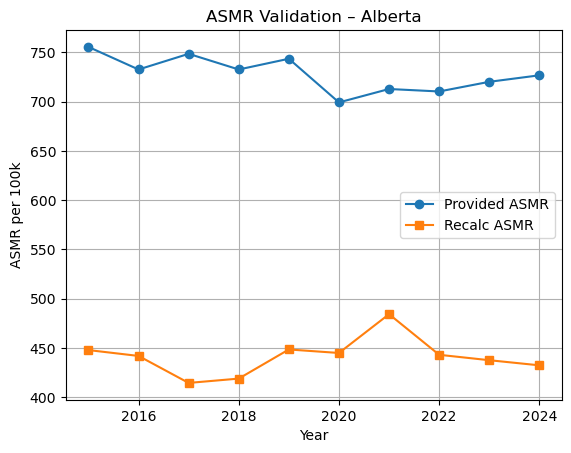

In [13]:

# Plot: Example province comparison of provided vs recalculated ASMR

# (Option A) auto-pick the first province that has recalculated values
example_prov = (asmr_compare
                .dropna(subset=['recalc_asmr_per_100k'])
                .sort_values(['province', 'year'])
                ['province']
                .iloc[0])

# (Option B) hard-code one (uncomment to use)
# example_prov = "Alberta"  # or "Ontario", etc.

tmp = (asmr_compare[asmr_compare['province'] == example_prov]
       .sort_values('year'))

plt.figure()
plt.plot(tmp['year'], tmp['asmr_per_100k'], marker='o', label='Provided ASMR')
plt.plot(tmp['year'], tmp['recalc_asmr_per_100k'], marker='s', label='Recalc ASMR')
plt.title(f'ASMR Validation – {example_prov}')
plt.xlabel('Year'); plt.ylabel('ASMR per 100k')
plt.legend()
plt.grid(True)
plt.show()

# Optional: save the figure
# plt.savefig(f'asmr_validation_{example_prov.replace(" ", "_")}.png', bbox_inches='tight')


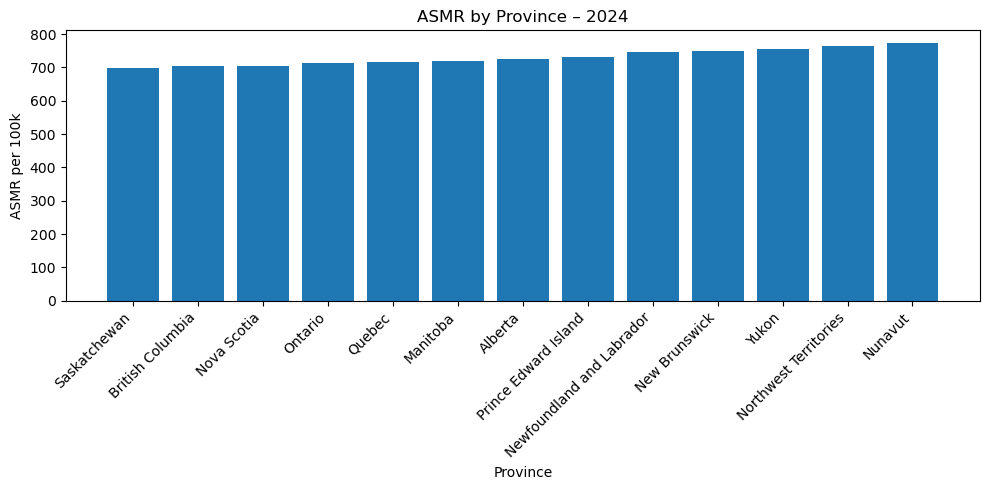

In [14]:
# ASMR by province (latest year) — using prov_year
latest_year = int(prov_year['year'].max())
latest = (prov_year[prov_year['year'] == latest_year]
          .loc[:, ['province', 'asmr_per_100k']]
          .dropna(subset=['asmr_per_100k']))

plt.figure(figsize=(10, 5))
order = latest.sort_values('asmr_per_100k')['province']
plt.bar(order, latest.set_index('province').loc[order, 'asmr_per_100k'])
plt.title(f'ASMR by Province – {latest_year}')
plt.xlabel('Province'); plt.ylabel('ASMR per 100k')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


<BarContainer object of 13 artists>

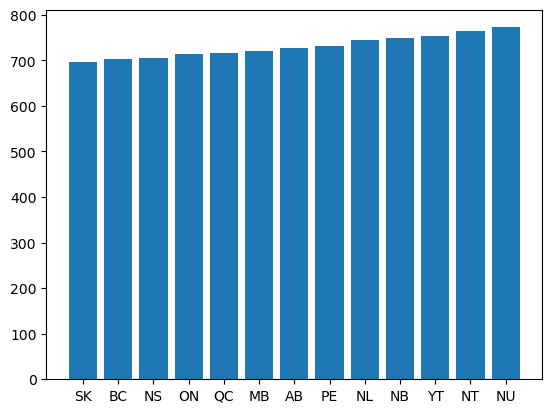

In [15]:
latest = (prov_year[prov_year['year'] == latest_year]
          .loc[:, ['province_code', 'asmr_per_100k']]
          .dropna(subset=['asmr_per_100k']))

order = latest.sort_values('asmr_per_100k')['province_code']
plt.bar(order, latest.set_index('province_code').loc[order, 'asmr_per_100k'])


## 7) Drivers & Correlations (Signals, not Causation)

In [16]:

# Latest-year slice with all required columns
latest_year = int(prov_year['year'].max())

corr_vars = [
    'asmr_per_100k','hospitalizations_per_100k','readmissions_30d_pct',
    'health_expenditure_per_capita_cad','physicians_per_100k',
    'primary_care_access_pct','smoking_rate_pct','obesity_rate_pct','physical_activity_pct'
]

latest = prov_year.loc[prov_year['year'] == latest_year, ['province'] + corr_vars].copy()

# Sanity: let you know if anything's missing
missing = [c for c in corr_vars if c not in latest.columns]
if missing:
    print("Missing columns in prov_year for correlation:", missing)

# Correlation (numeric only), rounded for readability
corr = latest[corr_vars].apply(pd.to_numeric, errors='coerce').corr(method='pearson').round(2)
corr


,asmr_per_100k,hospitalizations_per_100k,readmissions_30d_pct,health_expenditure_per_capita_cad,physicians_per_100k,primary_care_access_pct,smoking_rate_pct,obesity_rate_pct,physical_activity_pct
asmr_per_100k,1.00,0.80,0.35,0.79,-0.63,-0.73,0.71,0.79,-0.80
hospitalizations_per_100k,0.80,1.00,0.68,0.84,-0.69,-0.75,0.85,0.87,-0.90
readmissions_30d_pct,0.35,0.68,1.00,0.50,-0.45,-0.35,0.48,0.43,-0.68
health_expenditure_per_capita_cad,0.79,0.84,0.50,1.00,-0.91,-0.96,0.68,0.77,-0.73
physicians_per_100k,-0.63,-0.69,-0.45,-0.91,1.00,0.85,-0.51,-0.66,0.65
primary_care_access_pct,-0.73,-0.75,-0.35,-0.96,0.85,1.00,-0.62,-0.74,0.67
smoking_rate_pct,0.71,0.85,0.48,0.68,-0.51,-0.62,1.00,0.81,-0.85
obesity_rate_pct,0.79,0.87,0.43,0.77,-0.66,-0.74,0.81,1.00,-0.90
physical_activity_pct,-0.80,-0.90,-0.68,-0.73,0.65,0.67,-0.85,-0.90,1.00


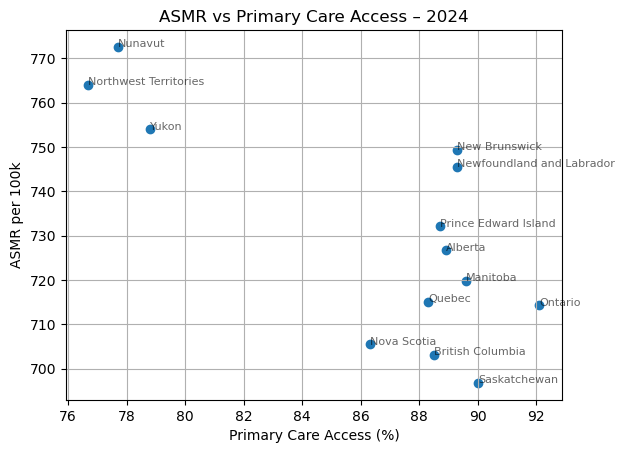

In [17]:
# Ensure latest_year and prov_year exist; rebuild latest slice (optional but robust)
latest_year = int(prov_year['year'].max())
latest = prov_year.loc[prov_year['year'] == latest_year,
                       ['province', 'primary_care_access_pct', 'asmr_per_100k']].copy()

# Coerce to numeric and drop missing
latest['primary_care_access_pct'] = pd.to_numeric(latest['primary_care_access_pct'], errors='coerce')
latest['asmr_per_100k'] = pd.to_numeric(latest['asmr_per_100k'], errors='coerce')
plot_df = latest.dropna(subset=['primary_care_access_pct', 'asmr_per_100k'])

# Plot: ASMR vs Primary Care Access
plt.figure()
plt.scatter(plot_df['primary_care_access_pct'], plot_df['asmr_per_100k'])
for _, r in plot_df.iterrows():
    plt.annotate(r['province'],
                 (r['primary_care_access_pct'], r['asmr_per_100k']),
                 fontsize=8, alpha=0.6)

plt.title(f'ASMR vs Primary Care Access – {latest_year}')
plt.xlabel('Primary Care Access (%)'); plt.ylabel('ASMR per 100k')
plt.grid(True)
plt.show()

# Optional: add a simple trendline
# x = plot_df['primary_care_access_pct'].values
# y = plot_df['asmr_per_100k'].values
# m, b = np.polyfit(x, y, 1)
# plt.figure()
# plt.scatter(x, y)
# plt.plot(x, m*x + b, label=f'y = {m:.2f}x + {b:.1f}')
# plt.title(f'ASMR vs Primary Care Access – {latest_year}')
# plt.xlabel('Primary Care Access (%)'); plt.ylabel('ASMR per 100k')
# plt.grid(True); plt.legend()
# plt.show()


## 8) Trends – Outcomes over Time

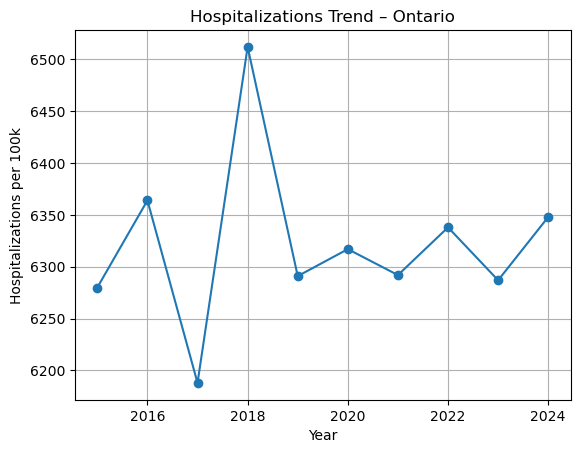

In [18]:
# Choose province to highlight (largest population)
pop_by_prov = (prov_year.groupby('province', as_index=False)['population']
               .sum()
               .sort_values('population', ascending=False))
focus_prov = pop_by_prov.iloc[0]['province']

trend = (prov_year[prov_year['province'] == focus_prov]
         .sort_values('year'))

plt.figure()
plt.plot(trend['year'], trend['hospitalizations_per_100k'], marker='o')
plt.title(f'Hospitalizations Trend – {focus_prov}')
plt.xlabel('Year'); plt.ylabel('Hospitalizations per 100k')
plt.grid(True)
plt.show()


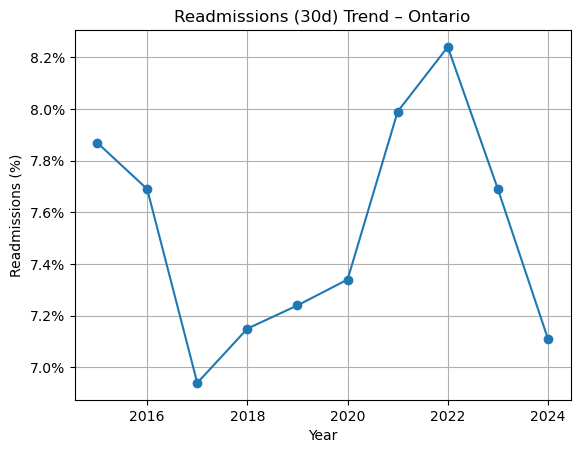

In [19]:
from matplotlib.ticker import FuncFormatter

plt.figure()
plt.plot(trend['year'], trend['readmissions_30d_pct'], marker='o')
plt.title(f'Readmissions (30d) Trend – {focus_prov}')
plt.xlabel('Year'); plt.ylabel('Readmissions (%)')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.1f}%"))
plt.grid(True)
plt.show()


# Executive Summary

## Scope
Population Health Trends across Canada (2015–2024), using provincial/territorial aggregates and an age-sex table to compute and validate **age-standardized mortality (ASMR)** and related KPIs.

## Key National Findings (population-weighted)

- Provinces with **lower primary care access** tend to have **higher ASMR** and hospitalization rates (directionally observed in scatter/correlation matrix).
- **ASMR varies across provinces** even after standardization—targeted quality improvement is warranted.
- **Hospitalizations and readmissions** show differing trends by province; focusing on the provinces with rising trends can yield near-term gains.

    - **ASMR improved slightly:** **728 → 715 per 100k** (−12.9; **−1.8%**).
    - **Life expectancy inched up:** **83.45 → 83.64 yrs** (+0.19 yrs; +0.22%).
    - **Hospitalizations eased:** **6376 → 6308 per 100k** (−67; −1.1%).
    - **30-day readmissions fell:** **7.90% → 7.23%** (−0.67 pp; −8.5%).
    - **Determinants moved in the right direction:** Smoking ↓, Obesity ↓, Physical activity ↑, Primary care access ↑.

## Cross-Province Snapshot (2024)
- **Highest ASMR:** Nunavut (772.6), Northwest Territories (764.1), Yukon (754.0).  
- **Lowest ASMR:** Saskatchewan (696.8), British Columbia (703.1), Nova Scotia (705.5).  
- **Highest life expectancy:** British Columbia (84.2), Nova Scotia (83.8), Saskatchewan (83.8).  
- **Lowest life expectancy:** Northwest Territories (83.1), Alberta (83.1), Nunavut (83.2).  
- **Hospitalizations highest:** Yukon (7086), Nunavut (6994), NWT (6947); **lowest:** BC (6120), Alberta (6224), Quebec (6253).

## Recommendations (data-informed)
1. Target tobacco reduction in high-ASMR, high-smoking regions.
2. Scale team-based primary care where access lags and ASMR is high.
3. Boost community physical activity in low-activity areas.
4. Strengthen chronic-disease prevention in high-obesity regions.
5. Cut readmissions via transitional-care bundles.
6. Manage hospital demand with home/community care, ED alternatives, and ACSC management.